In [1]:
from pathlib import Path

import folium
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from shapely.geometry import Point
import rasterio
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

from estuary.util import broad_band, false_color

In [ ]:
skipped_regions = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].to_list()

In [ ]:
gdf = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data_w_usgs.geojson")
gdf = gdf[~gdf["Site code"].isin(skipped_regions)].copy()
gdf = gdf.set_index("Site code")
gdf.head()

In [ ]:
rect_df = []

for pth in Path("/Volumes/x10pro/estuary/ca_grids/").iterdir():
    gid = int(pth.stem)
    if gid in skipped_regions:
        continue
    tp_df = gpd.read_file(pth)
    geo = tp_df.iloc[0].geometry
    rect_df.append({"Site code": gid, "geometry": geo, "Site name": gdf.loc[gid]["Site name"]})

rect_df = gpd.GeoDataFrame(rect_df, geometry="geometry", crs=tp_df.crs)
rect_df.head()

In [ ]:
mm = []
for site_code, row in gdf.iterrows():
    matches = rect_df[rect_df.intersects(row.geometry)]
    if len(matches) and (matches["Site code"] == site_code).all():
        mm.append(site_code)
gdf.loc[(rect_df[~rect_df["Site code"].isin(mm)]["Site code"])]

In [ ]:
df = pd.read_csv("/Users/kyledorman/Downloads/EMPA_Field_Grab.csv")
df = df[df.latitude > -87]
df.loc[df.longitude > 0, "longitude"] = df[df.longitude > 0].longitude * -1
df = df[df.tide != "Not recorded"]

# Step 1: parse as datetime (no tz yet)
df["samplecollectiondate"] = pd.to_datetime(df["samplecollectiondate"], errors="coerce")

# Step 2: localize to Pacific at midnight
df["samplecollectiondate"] = (
    df["samplecollectiondate"]
    .dt.tz_localize("America/Los_Angeles")
    # Step 3: shift to noon
    .dt.floor("D")
    + pd.Timedelta(hours=12)
)

# Step 4: convert to UTC for storage
df["samplecollectiondate"] = df["samplecollectiondate"].dt.tz_convert("UTC")
df.head()

In [ ]:
rpoints = {}
for r, rows in df.groupby(["siteid", "stationno"]):
    lon = rows.longitude.median()
    lat = rows.latitude.median()
    rpoints[r] = Point(lon, lat)

len(rpoints)

In [ ]:
# Convert lat/lon to shapely Points
geometry = [rpoints[(r.siteid, r.stationno)] for _, r in df.iterrows()]

# Create a GeoDataFrame
empa_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

empa_gdf.head()

In [ ]:
all_sensors = gpd.GeoDataFrame(
    [{"siteid": s, "stationno": ss, "geometry": p} for (s, ss), p in rpoints.items()], crs="wgs84"
)

nearests = (
    gpd.sjoin_nearest(
        all_sensors.to_crs("ESRI:54008"),
        gdf[["geometry", "Site name"]].to_crs("ESRI:54008"),
        how="inner",
        max_distance=1700,
        distance_col="dist",
    )
    .sort_values(by=["Site code", "dist", "siteid"])
    .drop_duplicates(["siteid", "Site code"])
)

# Manualally reviewed and filtered
nearests = nearests[nearests.siteid != "SC-CARP"]

nearests

In [ ]:
matching_sites = {}
for _, row in nearests.iterrows():
    if row["Site code"] in matching_sites:
        continue
    matching_sites[row["Site code"]] = row.siteid

revmatching_sites = {v: k for k, v in matching_sites.items()}

# with open("/Users/kyledorman/data/estuary/geos/ca_empa_matching_sites.json", "w") as f:
#     json.dump(matching_sites, f)

matching_sites

In [ ]:
filt_empa_gdf = empa_gdf[empa_gdf.siteid.isin(list(matching_sites.values()))].copy()
filt_empa_gdf.head()

In [ ]:
filt_empa_gdf.tide.unique()

In [ ]:
for (s, d), rows in filt_empa_gdf.groupby(["estuaryname", "samplecollectiondate"]):
    if not (rows.tide == rows.iloc[0].tide).all():
        print(s, d)
        print(rows.tide.tolist())

In [ ]:
filt_empa_gdf["mouth_closed"] = filt_empa_gdf.tide == "closed"

empa_labels = filt_empa_gdf.groupby(["estuaryname", "samplecollectiondate"], as_index=False).agg(
    {"mouth_closed": "any"}
)
empa_labels["Site code"] = -1
empa_labels["siteid"] = ""
for idx, row in empa_labels.iterrows():
    siteid = filt_empa_gdf[filt_empa_gdf.estuaryname == row.estuaryname].siteid.iloc[0]
    code = revmatching_sites[siteid]
    empa_labels.loc[idx, "Site code"] = code
    empa_labels.loc[idx, "siteid"] = siteid

print(len(empa_labels))

empa_labels.head()

In [ ]:
# Convert to numeric: open=1, closed=0
empa_labels["mouth_status"] = (~empa_labels["mouth_closed"]).astype(int)

# One figure
plt.figure(figsize=(8, 4))

# Plot each estuary separately
for estuary, g in empa_labels.groupby("estuaryname"):
    g = g.sort_values("samplecollectiondate")
    plt.scatter(
        g["samplecollectiondate"],
        g["mouth_status"],
        marker="o",
        label=estuary,
        s=5,
    )

plt.yticks([0, 1], ["Closed", "Open"])
plt.ylabel("Mouth Status")
plt.title("Estuary Mouth Status Over Time")
plt.legend(
    title="Estuary",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),  # push down below x-axis
    ncol=3,  # spread entries into columns
)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
empa_labels.groupby("estuaryname", as_index=False).agg(
    total_count=("mouth_closed", "size"), closed_pct=("mouth_closed", "mean")
).round(2)

In [ ]:
lookup = dict(zip(df.siteid, df.estuaryname, strict=False))
revlookup = dict(zip(df.estuaryname, df.siteid, strict=False))

sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
        if s in list(matching_sites.values())
    ],
    crs="wgs84",
)
# sensors.to_file("/Users/kyledorman/data/estuary/geos/filtered_empa_sites.geojson")

lookup = dict(zip(df.siteid, df.estuaryname, strict=False))

sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
    ],
    crs="wgs84",
)
# sensors.to_file("/Users/kyledorman/data/estuary/geos/empa_sites.geojson")

In [ ]:
sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
        if s not in list(matching_sites.values())
    ],
    crs="wgs84",
)

aaa = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data.geojson")
aaa = aaa[~aaa["Site code"].isin(list(matching_sites.keys()))]

# Initialize map centered on all data
bounds = aaa.total_bounds  # [minx, miny, maxx, maxy]
m = folium.Map(location=[(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2], zoom_start=8)

# Add sites (one color)
for _, row in aaa.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color="black",
        fill=True,
        fill_color="black",
        popup=f"Site: {row['Site code']}",
    ).add_to(m)

# Add sensor type 1
for _, row in sensors.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="red", icon="circle", prefix="fa"),
        popup=f"Sensor: {row['estuaryname']}",
    ).add_to(m)

# Show the map
m

In [ ]:
sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
        if s in list(matching_sites.values())
    ],
    crs="wgs84",
)

aaa = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data.geojson")
aaa = aaa[aaa["Site code"].isin(list(matching_sites.keys()))]

# Assume your GeoDataFrames are in EPSG:4326 (lat/lon).
# If not, reproject:
# gdf = gdf.to_crs(epsg=4326)

# Initialize map centered on all data
bounds = aaa.total_bounds  # [minx, miny, maxx, maxy]
m = folium.Map(location=[(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2], zoom_start=8)

# Add sites (one color)
for _, row in aaa.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color="black",
        fill=True,
        fill_color="black",
        popup=f"Site: {row['Site code']}",
    ).add_to(m)

# Add sensor type 1
for _, row in sensors.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="red", icon="circle", prefix="fa"),
        popup=f"Sensor: {row['estuaryname']}",
    ).add_to(m)

# Show the map
m

In [ ]:
skipped = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")["Site code"].to_list()
ss_labels = pd.read_csv("/Volumes/x10pro/estuary/skysat/labels.csv")
ss_labels["acquired"] = pd.to_datetime(ss_labels["acquired"], errors="coerce").dt.tz_localize(
    "UTC"
)  # interpret naive times as already UTC
ss_labels["year"] = ss_labels.acquired.dt.year
ss_labels["month"] = ss_labels.acquired.dt.month
ss_labels = ss_labels[~ss_labels.region.isin(skipped)].copy()
ss_labels.head()

In [ ]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
period = pd.PeriodIndex(year=ss_labels["year"], month=ss_labels["month"], freq="M")

# Counts per month (sorted)
counts = period.value_counts().sort_index()

# Fill missing months between start and end
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month")

# Only label every nth month for readability
labels = [p.strftime("%Y-%m") for p in counts.index]
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
for region, rdf in ss_labels.groupby("region"):
    ddf = empa_labels[empa_labels["Site code"] == region]
    if not len(ddf):
        continue

    ddf = ddf.sort_values("samplecollectiondate").reset_index(drop=True)
    rdf = rdf.sort_values("acquired").reset_index(drop=True)

    # Nearest match within n days
    pairs = pd.merge_asof(
        ddf,
        rdf,
        left_on="samplecollectiondate",
        right_on="acquired",
        direction="nearest",
        tolerance=pd.Timedelta("2D"),
        suffixes=("_d", "_r"),
    )
    pairs = pairs[~pairs.region.isna()]
    if len(pairs):
        print(pairs[["Site code", "estuaryname", "samplecollectiondate", "mouth_closed", "label"]])

In [ ]:
ss_empa_labels = ss_labels.copy()
ss_empa_labels["source"] = "skysat"
to_add = []
for _, row in empa_labels.iterrows():
    to_add.append(
        {
            "region": row["Site code"],
            "label": "closed" if row.mouth_closed else "open",
            "source": "empa",
            "acquired": row.samplecollectiondate,
        }
    )
ss_empa_labels = pd.concat([ss_empa_labels, pd.DataFrame(to_add)])
# ss_empa_labels.to_csv("/Volumes/x10pro/estuary/skysat/labels_empa.csv")
ss_empa_labels.head()

In [ ]:
dove = []
for base in [
    Path("/Volumes/x10pro/estuary/dove/results"),
    Path("/Volumes/x10pro/estuary/superdove/results"),
]:
    for pth in base.glob("*/*/*/images_to_download.csv"):
        df = pd.read_csv(pth).drop(columns=["ordered_idx"])
        df["region"] = int(pth.parent.name)
        df["capture_datetime"] = pd.to_datetime(
            df["capture_datetime"], errors="coerce"
        ).dt.tz_localize("UTC")  # interpret naive times as already UTC
        df["dove"] = base.parent.name
        dove.append(df)

dove_df = pd.concat(dove)

# Add ISO year and ISO week
dove_df["year"] = dove_df.capture_datetime.dt.year
dove_df["month"] = dove_df.capture_datetime.dt.month
dove_df["week"] = dove_df.capture_datetime.dt.isocalendar().week
dove_df["week2"] = dove_df.capture_datetime.dt.isocalendar().week // 2

dove_df = dove_df[dove_df.include_image]

print(len(dove_df))

dove_df.head()

In [ ]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
period = pd.PeriodIndex.from_fields(year=dove_df["year"], month=dove_df["month"], freq="M")

# Counts per month (sorted)
counts = period.value_counts().sort_index()

# Fill missing months between start and end
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month")

# Only label every nth month for readability
labels = [p.strftime("%Y-%m") for p in counts.index]
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
ss_empa_labels = (
    ss_empa_labels[ss_empa_labels.label != "unsure"].sort_values("acquired").reset_index(drop=True)
)
dove_df = dove_df.sort_values("capture_datetime").reset_index(drop=True)

tol = pd.Timedelta("14h")

# cross-join within region, then filter by window
tmp = dove_df.merge(ss_empa_labels, on="region", suffixes=("_dd", "_ss"))
mask = (tmp["acquired"] >= tmp["capture_datetime"] - tol) & (
    tmp["acquired"] <= tmp["capture_datetime"] + tol
)
pairs = tmp.loc[mask].sort_values(["region", "capture_datetime", "acquired"])

pairs = pairs.drop(columns=["year_ss", "month_ss"]).rename(
    columns={"year_dd": "year", "month_dd": "month"}
)
# pairs = pd.merge_asof(
#     dove_df,
#     ss_empa_labels,
#     by="region",
#     right_on="acquired",
#     left_on="capture_datetime",
#     direction="nearest",
#     tolerance=pd.Timedelta("28h"),
#     suffixes=("_dd", "_ss"),
# )
# pairs = pairs[~pairs.source_tif.isna()]
len(pairs)

In [ ]:
pairs.head()

In [ ]:
pairs_dedup = pairs.sort_values(
    by=["region", "year", "month", "dove", "label", "source"],
    ascending=[True, True, True, False, True, True],
).drop_duplicates(["region", "year", "month", "label"])

len(pairs_dedup)

In [ ]:
len(pairs_dedup[pairs_dedup.source == "empa"])

In [ ]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
period = pd.PeriodIndex.from_fields(year=pairs_dedup["year"], month=pairs_dedup["month"], freq="M")

# Counts per month (sorted)
counts = period.value_counts().sort_index()

# Fill missing months between start and end
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month")

# Only label every nth month for readability
labels = [p.strftime("%Y-%m") for p in counts.index]
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
missed_regions = set(rect_df["Site code"].unique()) - set(pairs_dedup.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = pairs_dedup.groupby(["region", "label"]).size().unstack(fill_value=0)

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0)

# Plot stacked bar chart
counts.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Counts per Region grouped by Label")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

In [ ]:
counts = pairs_dedup["label"].value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Number of Records per Label")
plt.tight_layout()
plt.show()

In [ ]:
counts = pairs_dedup["dove"].value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Satellite")
plt.ylabel("Count")
plt.title("Number of Records per Satellite Type")
plt.tight_layout()
plt.show()

In [ ]:
pairs_dedup["source"].value_counts()

In [ ]:
to_download = []
for (region, month, year), df in dove_df.groupby(["region", "month", "year"]):
    super_label_df = pairs_dedup[
        (pairs_dedup.region == region) & (pairs_dedup.year == year) & (pairs_dedup.month == month)
    ]
    if len(super_label_df):
        to_download.append(super_label_df[["region", "year", "month", "asset_id", "dove"]])
    else:
        to_download.append(df[["region", "year", "month", "asset_id", "dove"]].iloc[0:1])

to_download = (
    pd.concat(to_download)
    .sort_values(["region", "year", "month", "dove", "asset_id"])
    .reset_index(drop=True)
)

print(len(to_download))
to_download.head()

In [ ]:
counts = to_download["dove"].value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Satellite")
plt.ylabel("Count")
plt.title("Number of Records per Satellite Type")
plt.tight_layout()
plt.show()

In [ ]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
# If you already have capture_datetime, easiest is to make a period column
to_download["period"] = pd.PeriodIndex.from_fields(
    year=to_download["year"], month=to_download["month"], freq="M"
)

# Group by month + dove, then unstack to make dove the stacked key
counts = to_download.groupby(["period", "dove"]).size().unstack(fill_value=0).sort_index()

# Fill in missing months across the full range
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month (stacked by Dove)")

# Sparse tick labels
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
missed_regions = set(rect_df["Site code"].unique()) - set(to_download.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = to_download.region.value_counts()

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0).sort_index()

# Plot stacked bar chart
counts.plot(kind="bar", figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Counts per Region")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
missed_regions = set(rect_df["Site code"].unique()) - set(dove_df.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = dove_df.region.value_counts()

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0).sort_index()

# Plot stacked bar chart
counts.plot(kind="bar", figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Counts per Region")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# base = Path("/Volumes/x10pro/estuary/")
# for (region, year, month, dove), df in to_download.groupby(["region", "year", "month", "dove"]):
#     df = df[["asset_id"]].copy()
#     if not len(df):
#         continue
#     df["include_image"] = True

#     save_path = base / dove / "results" / str(year) / str(month) / str(region) / "subset_images_to_download.csv"
#     assert save_path.parent.exists()
#     df.to_csv(save_path)


In [ ]:
d_df = pd.read_csv("/Volumes/x10pro/estuary/dove/labels.csv")
d_df["acquired"] = pd.to_datetime(d_df["acquired"], errors="coerce").dt.tz_localize(
    "UTC"
)  # interpret naive times as already UTC
d_df["year"] = d_df.acquired.dt.year
d_df["month"] = d_df.acquired.dt.month
d_df = d_df[d_df["label"] != "unsure"].copy()
d_df = d_df[~d_df.region.isin(skipped)].copy()

print("Num Regions:", len(d_df.region.unique()), "Num images:", len(d_df))
d_df.head()

In [ ]:
missed_regions = set(rect_df["Site code"].unique()) - set(d_df.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = d_df.groupby(["region", "label"]).size().unstack(fill_value=0)

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0)

# Plot stacked bar chart
counts.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Dove Label Counts per Region grouped by Label")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

In [ ]:
counts = d_df.label.value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(5, 4))
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Count per Label type")
plt.tight_layout()
plt.show()

In [ ]:
ss_empa_labels[(~ss_empa_labels.source_tif.isna())].region.unique().size

In [ ]:
tmp = d_df.merge(ss_empa_labels, on="region", suffixes=("_dd", "_ss"))
tol = pd.Timedelta("14h")
mask = (tmp["acquired_dd"] >= tmp["acquired_ss"] - tol) & (
    tmp["acquired_dd"] <= tmp["acquired_ss"] + tol
)
dove_pairs = tmp.loc[mask].sort_values(["region", "acquired_dd", "acquired_ss"])

dove_pairs = dove_pairs.drop(columns=["year_ss", "month_ss"]).rename(
    columns={"year_dd": "year", "month_dd": "month"}
)

print(len(dove_pairs))

dove_pairs.head()

In [ ]:
labels = ["closed", "perched open", "open"]
aaa = dove_pairs[dove_pairs.source != "empa"]
y_true = [labels.index(l) for l in aaa.label_ss]
y_pred = [labels.index(l) for l in aaa.label_dd]

print("Accuracy", round(100 * accuracy_score(y_true, y_pred), 1))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)

In [ ]:
labels = ["closed", "open"]
aaa = dove_pairs[dove_pairs.source != "empa"]
y_true = [int("open" in l) for l in aaa.label_ss]
y_pred = [int("open" in l) for l in aaa.label_dd]

print("Accuracy", round(100 * accuracy_score(y_true, y_pred), 1))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)

In [ ]:
aaa = dove_pairs[dove_pairs.source == "empa"]
labels = ["closed", "open"]
y_true = [int("open" in l) for l in aaa.label_ss]
y_pred = [int("open" in l) for l in aaa.label_dd]

print("Accuracy", round(100 * accuracy_score(y_true, y_pred), 1))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)

In [ ]:
import numpy as np

empa_closed = dove_pairs[
    (dove_pairs.source == "empa")
    & (dove_pairs.label_dd != "closed")
    & (dove_pairs.label_ss == "closed")
]
empa_open = dove_pairs[
    (dove_pairs.source == "empa")
    & (dove_pairs.label_dd == "closed")
    & (dove_pairs.label_ss != "closed")
]

fig, axes = plt.subplots(ncols=2, nrows=len(empa_open), figsize=(10, 5 * len(empa_open)))
if len(axes.shape) == 1:
    axes = [axes]

for i, (_, row) in enumerate(empa_closed.iterrows()):
    with rasterio.open(row.source_tif_dd) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)
    axes[i][0].axis("off")
    axes[i][0].imshow(img)
    if i == 0:
        axes[i][0].set_title("close")

for i, (_, row) in enumerate(empa_open.iterrows()):
    with rasterio.open(row.source_tif_dd) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)
    axes[i][1].axis("off")
    axes[i][1].imshow(img)
    if i == 0:
        axes[i][1].set_title("open")

fig.tight_layout()
plt.show()

In [ ]:
# inspect = dove_pairs[
#     ((
#         (dove_pairs.label_ss == "closed") &
#         (dove_pairs.label_dd != "closed")
#     ) |
#     (
#         (dove_pairs.label_ss != "closed") &
#         (dove_pairs.label_dd == "closed")
#     )) &
#     (dove_pairs.source == "skysat")
# ]

# save_path = Path("/Volumes/x10pro/estuary/inspect_28")
# save_path.mkdir(exist_ok=True, parents=True)
# for _, row in inspect.iterrows():
#     region = row.region
#     year = row.year
#     month = row.month

#     with rasterio.open(row.source_tif_dd) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask
#         if len(data) == 4:
#             img = false_color(data, nodata)
#         else:
#             img = broad_band(data, nodata)
#         dd_img = Image.fromarray(img)

#     with rasterio.open(row.source_tif_ss) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask
#         if len(data) == 4:
#             img = false_color(data, nodata)
#         else:
#             img = broad_band(data, nodata)
#         ss_img = Image.fromarray(img)

#     dd_img = dd_img.resize(ss_img.size)

#     # You can load a TTF font; fallback to default
#     try:
#         font = ImageFont.truetype("arial.ttf", 72)
#     except IOError:
#         font = ImageFont.load_default(72)

#     # Top-right for first image
#     # Draw text (top-right corner of each)
#     draw = ImageDraw.Draw(ss_img)
#     text1 = "-".join(row.label_ss.split(" "))
#     w1 = draw.textlength(text1, font=font)
#     draw.text((ss_img.width - w1 - 5, 5), text1, fill="white", font=font)

#     # Top-right for second image
#     draw = ImageDraw.Draw(dd_img)
#     text2 = "-".join(row.label_dd.split(" "))
#     w2 = draw.textlength(text2, font=font)
#     draw.text((dd_img.width - w2 - 5, 5), text2, fill="white", font=font)

#     # Concatenate horizontally
#     total_width = ss_img.width + ss_img.width
#     max_height = max(ss_img.height, ss_img.height)
#     new_im = Image.new("RGB", (total_width, max_height))

#     new_im.paste(ss_img, (0, 0))
#     new_im.paste(dd_img, (ss_img.width, 0))

#     # Save
#     new_im.save(save_path / f"{region}_{year}-{month}_{text1}.png")

In [ ]:
gdf["empa_site_id"] = None
for region, _ in gdf.iterrows():
    gdf.loc[region, "empa_site_id"] = matching_sites.get(region)

label_pcts = d_df.groupby("region")["label"].value_counts(normalize=True).unstack(fill_value=0)
label_pcts.index.name = "Site code"

labeled_gdf = gdf.join(label_pcts)

labeled_gdf.head(5)

In [ ]:
labeled_gdf[~labeled_gdf.empa_site_id.isna() & ~labeled_gdf.station_nm.isna()]

In [ ]:
TEST_SITES = [72]
VAL_SITES = []
TRAIN_SITES = []

In [ ]:
labeled_gdf[~labeled_gdf.empa_site_id.isna()]

In [ ]:
TEST_SITES.extend([11, 18, 48, 50])
VAL_SITES.extend([21, 25, 51, 2145])
TRAIN_SITES.extend([28, 43, 84, 2161, 2162, 2163])

In [ ]:
labeled_gdf[~labeled_gdf.site_no.isna()]

In [ ]:
TEST_SITES.extend([15, 27])
VAL_SITES.extend([16, 56, 77])
TRAIN_SITES.extend([17, 2147, 57])

In [ ]:
len(VAL_SITES)

In [ ]:
remainder = set(d_df.region.unique().tolist()) - set(TEST_SITES) - set(VAL_SITES) - set(TRAIN_SITES)
TRAIN_SITES.extend(remainder)

print(len(TRAIN_SITES))

In [ ]:
splits = []
for r in TRAIN_SITES:
    splits.append({"region": r, "is_train": True, "is_test": False, "is_val": False})
for r in TEST_SITES:
    splits.append({"region": r, "is_test": True, "is_train": False, "is_val": False})
for r in VAL_SITES:
    splits.append({"region": r, "is_val": True, "is_test": False, "is_train": False})
splits = pd.DataFrame(splits).sort_values("region")
splits

In [ ]:
splits.to_csv("/Volumes/x10pro/estuary/dataset/region_splits.csv", index=False)

In [ ]:
len(dove_df[dove_df.dove == "dove"]), len(dove_df[dove_df.dove == "superdove"])

In [ ]:
len(to_download[to_download.dove == "dove"]), len(to_download[to_download.dove == "superdove"])

In [ ]:
print(
    "superdove",
    5.8 / (to_download.dove == "superdove").sum() * (dove_df.dove == "superdove").sum() / 92 * 2245,
)
print("dove", 3.4 / (to_download.dove == "dove").sum() * (dove_df.dove == "dove").sum() / 92 * 2245)
print("skysat", 29 / 92 * 2245)

print("train images", len(d_df) / 92 * 2245)

print("inference images", len(dove_df) / 92 * 2245)

print("skysat images", len(ss_labels) / 92 * 2245)

In [ ]:
all_images = list(
    Path("/Volumes/x10pro/estuary/ca_all/").glob("*/results/*/*/*/files/*_AnalyticMS_SR*.tif")
)
all_images[:10]

In [ ]:
all_images[0].parents[2].name

In [ ]:
from estuary.model.data import parse_dt_from_pth

all_df = []
for p in all_images:
    dt = parse_dt_from_pth(p)
    region = int(p.parents[1].name)
    if region in skipped_regions:
        continue
    all_df.append(
        {
            "pth": str(p),
            "acquired": dt,
            "year": int(p.parents[3].name),
            "month": int(p.parents[2].name),
            "day": dt.day,
            "region": region,
        }
    )

all_df = pd.DataFrame(all_df)
all_df = all_df.sort_values(by=["region", "acquired"]).reset_index(drop=True)
all_df = all_df.drop_duplicates(["region", "year", "month", "day"])

print(len(all_df))

all_df.head(5)

In [ ]:
all_df.region.value_counts().hist()

In [ ]:
region_counts = all_df.region.value_counts().sort_values()

N = 5
largest_counts = region_counts.tail(N)
smallest_counts = region_counts.head(N)

display(smallest_counts)
display(largest_counts)

In [ ]:
all_df["delta_days"] = all_df.groupby("region")["acquired"].diff().dt.total_seconds() / (24 * 3600)

# 3. Compute quantiles per region
summary = (
    all_df.groupby("region")["delta_days"]
    .quantile([0.5, 0.95, 0.99])  # 0.5 = p50, 0.95 = p95
    .unstack(level=-1)
    .rename(columns={0.5: "p50_days", 0.95: "p95_days", 0.99: "p99_days"})
)

summary.round(3).to_csv("/Users/kyledorman/data/estuary/display/ca_site_temporal.csv")

summary.round(1)

In [ ]:
N = 5
# Top N worst (largest) p95
worst_p95 = summary.sort_values("p95_days", ascending=False).head(N)

# Top N worst (largest) p99
worst_p99 = summary.sort_values("p99_days", ascending=False).head(N)

display(worst_p95.round(1))
display(worst_p99.round(1))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mv = np.ceil(summary["p99_days"].max())
bins = np.linspace(0, mv, int(mv) // 2 + 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

summary["p50_days"].hist(ax=axes[0], bins=bins, color="skyblue", edgecolor="k")
axes[0].set_title("Distribution of p50 (days)")
axes[0].set_ylabel("Number of regions")
axes[0].set_xlabel("Days between acquisitions")

summary["p95_days"].hist(ax=axes[1], bins=bins, color="salmon", edgecolor="k")
axes[1].set_title("Distribution of p95 (days)")

summary["p99_days"].hist(ax=axes[2], bins=bins, color="teal", edgecolor="k")
axes[2].set_title("Distribution of p99 (days)")

plt.tight_layout()
plt.savefig("/Users/kyledorman/data/estuary/display/ca_time_between.png")
plt.show()

In [ ]:
gdf.head()

In [ ]:
import folium
import geopandas as gpd
from branca.colormap import linear

gdf["region"] = gdf.index

# Suppose:
# - summary has index "region" and columns including p99_days
# - gdf is a GeoDataFrame with a "region" column and Point geometries

# 2. Join stats to gdf
gdf_stats = gdf.merge(summary[["p95_days"]], on="region", how="inner")

# 3. Create folium map, centered roughly on your data
m = folium.Map(
    location=[gdf_stats.geometry.y.mean(), gdf_stats.geometry.x.mean()],
    zoom_start=6,
    tiles="cartodbpositron",
    width=600,
    height=600,
)

# 4. Set up color scale for p99 values
colormap = linear.YlOrRd_09.scale(gdf_stats["p95_days"].min(), gdf_stats["p95_days"].max())
colormap.caption = "p95 days between acquisitions"

# 5. Add points with colors
for _, row in gdf_stats.iterrows():
    if pd.notnull(row["p95_days"]):
        color = colormap(row["p95_days"])
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            fill=True,
            fill_opacity=0.8,
            color=color,
            popup=f"Region: {row['region']}<br>p99: {row['p95_days']:.1f} days",
        ).add_to(m)

# 6. Add colorbar legend
colormap.add_to(m)

m

In [10]:
dove_labels = pd.read_csv("/Volumes/x10pro/estuary/ca_all/dove/labels.csv")
dove_labels["acquired"] = pd.to_datetime(dove_labels["acquired"], errors="coerce")
dove_labels = dove_labels[dove_labels.label != "unsure"].reset_index(drop=True).sort_values(["region", "acquired"])
ss_labels = pd.read_csv("/Volumes/x10pro/estuary/skysat/labels.csv")
ss_labels["acquired"] = pd.to_datetime(ss_labels["acquired"], errors="coerce")
ss_labels = ss_labels[ss_labels.label != "unsure"].reset_index(drop=True).sort_values(["region", "acquired"])

tol = pd.Timedelta("14h")

# cross-join within region, then filter by window
tmp = dove_labels.merge(ss_labels, on="region", suffixes=("_dd", "_ss"))
mask = (tmp["acquired_dd"] >= tmp["acquired_ss"] - tol) & (
    tmp["acquired_dd"] <= tmp["acquired_ss"] + tol
)
pairs = tmp.loc[mask].sort_values(["region", "acquired_dd"])

pairs.head()

,region,source_tif_dd,label_dd,acquired_dd,instrument_dd,source_tif_ss,source_jpeg,label_ss,acquired_ss,instrument_ss
1596,21,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-12 18:01:06,dove,/Volumes/x10pro/estuary/skysat/results/2017/21...,/Volumes/x10pro/estuary/ca_labeling/00077/imag...,closed,2017-12-12 18:45:18,skysat
1636,21,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-17 18:02:18,dove,/Volumes/x10pro/estuary/skysat/results/2017/21...,/Volumes/x10pro/estuary/ca_labeling/00077/imag...,closed,2017-12-17 18:37:46,skysat
1656,21,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-18 18:01:26,dove,/Volumes/x10pro/estuary/skysat/results/2017/21...,/Volumes/x10pro/estuary/ca_labeling/00077/imag...,closed,2017-12-18 18:37:35,skysat
1695,21,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-26 18:02:59,dove,/Volumes/x10pro/estuary/skysat/results/2017/21...,/Volumes/x10pro/estuary/ca_labeling/00077/imag...,closed,2017-12-26 18:42:32,skysat
5363,21,/Volumes/x10pro/estuary/ca_all/dove/results/20...,open,2019-04-12 17:31:35,dove,/Volumes/x10pro/estuary/skysat/results/2019/21...,/Volumes/x10pro/estuary/ca_labeling/00077/imag...,open,2019-04-12 18:34:27,skysat


In [11]:
pairs.groupby("region").label_dd.count()

region
21      13
28      69
51       4
84       9
2145     6
Name: label_dd, dtype: int64

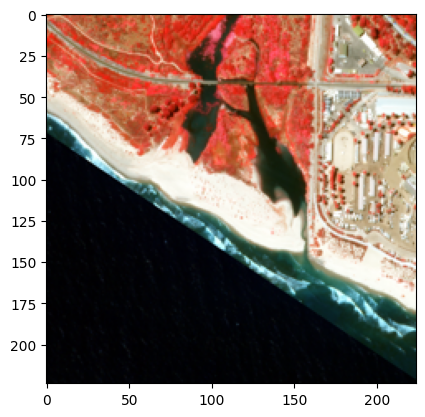

In [12]:
plt.figure()
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/21/files/*pansharpened_clip.tif")
)[0]
with rasterio.open(pth) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
    img = Image.fromarray(img).resize((224, 224))
    # .save("/Users/kyledorman/data/estuary/display/region_53.png")
plt.imshow(img)

In [21]:
ventura = pairs[pairs.region == 21][["source_tif_dd", "label_dd", "acquired_dd", "source_tif_ss", "label_ss", "acquired_ss"]].reset_index(drop=True)
ventura["time_diff"] = (ventura.acquired_dd - ventura.acquired_ss).abs()
ventura["label_match"] = ventura.label_dd == ventura.label_ss
ventura.head()

,source_tif_dd,label_dd,acquired_dd,source_tif_ss,label_ss,acquired_ss,time_diff,label_match
0,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-12 18:01:06,/Volumes/x10pro/estuary/skysat/results/2017/21...,closed,2017-12-12 18:45:18,0 days 00:44:12,True
1,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-17 18:02:18,/Volumes/x10pro/estuary/skysat/results/2017/21...,closed,2017-12-17 18:37:46,0 days 00:35:28,True
2,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-18 18:01:26,/Volumes/x10pro/estuary/skysat/results/2017/21...,closed,2017-12-18 18:37:35,0 days 00:36:09,True
3,/Volumes/x10pro/estuary/ca_all/dove/results/20...,closed,2017-12-26 18:02:59,/Volumes/x10pro/estuary/skysat/results/2017/21...,closed,2017-12-26 18:42:32,0 days 00:39:33,True
4,/Volumes/x10pro/estuary/ca_all/dove/results/20...,open,2019-04-12 17:31:35,/Volumes/x10pro/estuary/skysat/results/2019/21...,open,2019-04-12 18:34:27,0 days 01:02:52,True


In [23]:
ventura[~ventura.label_match]

,source_tif_dd,label_dd,acquired_dd,source_tif_ss,label_ss,acquired_ss,time_diff,label_match
11,/Volumes/x10pro/estuary/ca_all/superdove/resul...,perched open,2022-08-07 18:32:03,/Volumes/x10pro/estuary/skysat/results/2022/21...,open,2022-08-07 21:41:15,0 days 03:09:12,False


In [25]:
ventura[["acquired_dd", "label_dd"]]

,acquired_dd,label_dd
0,2017-12-12 18:01:06,closed
1,2017-12-17 18:02:18,closed
2,2017-12-18 18:01:26,closed
3,2017-12-26 18:02:59,closed
4,2019-04-12 17:31:35,open
5,2019-10-15 18:21:43,open
6,2019-10-19 18:17:39,open
7,2021-05-03 18:18:05,open
8,2021-11-14 17:51:23,closed
9,2022-01-18 17:48:54,open


In [28]:
2017-12-18
2019-04-12
# 2019-10-19
2021-05-03
# 2021-11-14
# 2022-01-18
2022-04-23

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (612235520.py, line 2)